In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
train_data = pd.read_csv('data/train_values.csv', index_col=0, parse_dates=['timestamp'])
train_labels = pd.read_csv('data/train_labels.csv', index_col=0)
test_data = pd.read_csv('data/test_values.csv', index_col=0, parse_dates=['timestamp'])


**Для начала воспользуемся бэнчмарком, данным на соревновании и попытаемся его улучшить:**

*Пропусков в данных практически нет(кроме последнего столбца)*

In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5987820 entries, 0 to 5987819
Data columns (total 35 columns):
process_id                    int64
object_id                     int64
phase                         object
timestamp                     datetime64[ns]
pipeline                      object
supply_flow                   float64
supply_pressure               float64
return_temperature            float64
return_conductivity           float64
return_turbidity              float64
return_flow                   float64
supply_pump                   bool
supply_pre_rinse              bool
supply_caustic                bool
return_caustic                bool
supply_acid                   bool
return_acid                   bool
supply_clean_water            bool
return_recovery_water         bool
return_drain                  bool
object_low_level              bool
tank_level_pre_rinse          float64
tank_level_caustic            float64
tank_level_acid               float64
tank

In [3]:
# subset to final rinse phase observations
#train_data.fillna(value=True, inplace=True)
final_phases = train_data[train_data['target_time_period']]
#just one process
final_phase = final_phases[final_phases['process_id'] == 20017]

In [4]:
# calculate target variable
final_phase = final_phase.assign(target=np.maximum(final_phase['return_flow'], 0) * final_phase['return_turbidity'])

In [5]:
final_phase.head()

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period,target
row_id,,,,,,,,,,,,,,,,,,,,,
13835,20017,204,final_rinse,2018-03-05 21:31:35,L2,8926.505,1.439019,53.754340,9.294569,0.383391,...,82.219330,72.276474,45.519928,45.603252,False,0.0,False,0.0,True,1454.634597
13836,20017,204,final_rinse,2018-03-05 21:31:37,L2,9009.693,1.465712,50.857204,8.735830,0.372540,...,82.219330,72.276474,45.518127,45.603252,False,0.0,False,0.0,True,1499.701905
13837,20017,204,final_rinse,2018-03-05 21:31:39,L2,9165.221,1.516927,48.470055,7.943024,0.368924,...,82.197624,72.276474,45.516660,45.603252,False,0.0,False,0.0,True,1682.626857
13838,20017,204,final_rinse,2018-03-05 21:31:41,L2,9252.025,1.560113,45.988860,7.108860,0.372540,...,82.197624,72.276474,45.514927,45.603252,False,0.0,False,0.0,True,1680.258986
13839,20017,204,final_rinse,2018-03-05 21:31:43,L2,9450.955,1.610677,43.645110,6.823575,0.354456,...,82.219330,72.276474,45.516262,45.603252,False,0.0,False,0.0,True,1553.821926


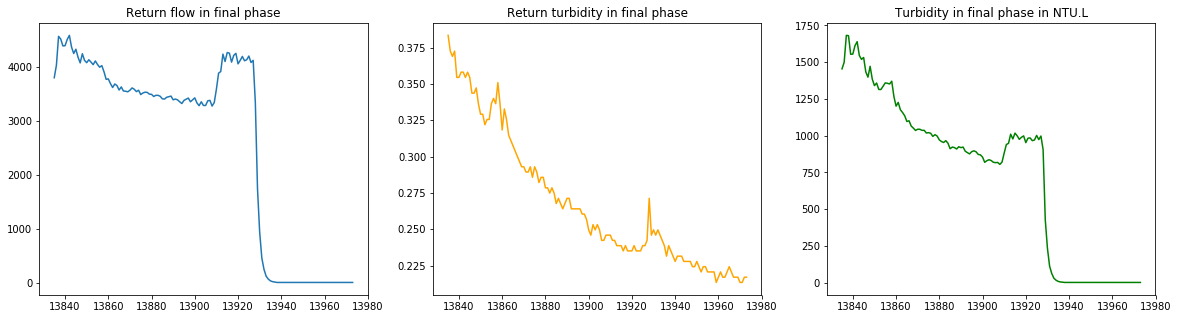

In [6]:
# plot flow, turbidity, and target 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax[0].plot(final_phase['return_flow'])
ax[0].set_title('Return flow in final phase')

ax[1].plot(final_phase['return_turbidity'], c='orange')
ax[1].set_title('Return turbidity in final phase')

ax[2].plot(final_phase['target'], c='green')
ax[2].set_title('Turbidity in final phase in NTU.L');

# Попробуем посмотреть на данные. Возможно, получится увидеть некоторые закономерности

In [7]:
import time
import csv
import pickle
import random
import time
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns

%matplotlib inline
pd.options.display.max_columns = None # выводить в датафрейме всё
%pylab inline
figsize(10, 3)


Populating the interactive namespace from numpy and matplotlib


In [8]:
train_data_ts = train_data.copy()
train_data_ts.index = train_data_ts['timestamp']

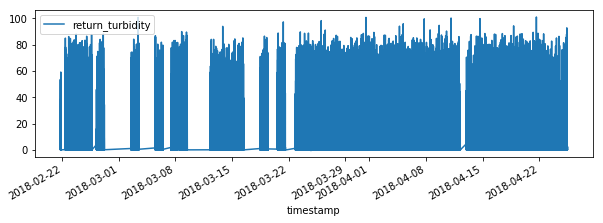

In [9]:
train_data_ts[['return_turbidity']].plot()

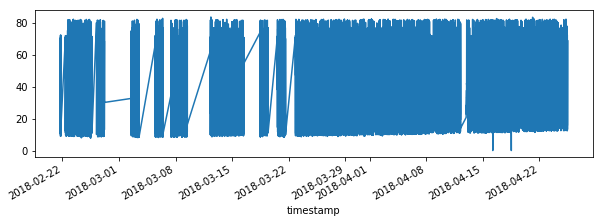

In [10]:
train_data_ts[train_data_ts['phase'] == 'final_rinse']['return_temperature'].plot()

In [11]:
train_data = train_data[train_data['phase'] != 'final_rinse']

In [12]:
#sum to get target
final_phase['target'].sum()

103724.28729467509

In [13]:
#confirm that value matches the target label for this process_id
train_labels.loc[20017]

final_rinse_total_turbidity_liter    103724.287295
Name: 20017, dtype: float64

Text(0.5, 1.0, 'Количество процессов в $N$-й фазе')

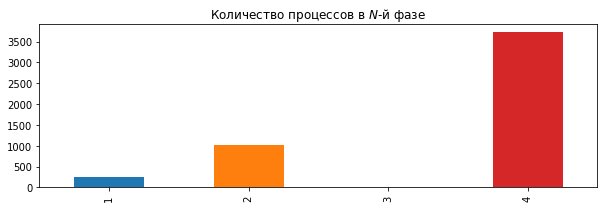

In [14]:
train_data.groupby('process_id')['phase'].nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов в $N$-й фазе")

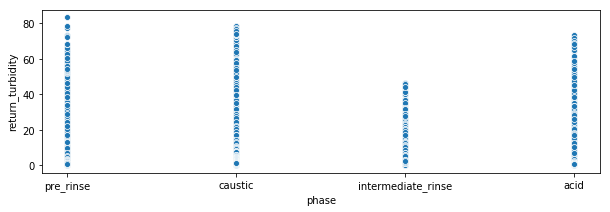

In [15]:
sns.scatterplot(train_data['phase'].head(100000), train_data['return_turbidity'].head(100000))

In [16]:
train_data

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,supply_pump,supply_pre_rinse,supply_caustic,return_caustic,supply_acid,return_acid,supply_clean_water,return_recovery_water,return_drain,object_low_level,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,20001,405,pre_rinse,2018-04-15 04:20:47,L4,8550.348,0.615451,18.044704,4.990765,0.177228,15776.9100,True,True,False,False,False,False,False,False,True,True,55.499672,41.555992,44.026875,49.474102,32.385708,83.036750,73.032410,45.394646,44.340126,False,0.0,False,0.0,False
1,20001,405,pre_rinse,2018-04-15 04:20:49,L4,11364.294,0.654297,18.229168,3.749680,0.122975,13241.4640,True,True,False,False,False,False,False,False,True,True,55.487920,41.624170,44.045685,49.457645,32.385708,83.015045,73.032410,45.394447,44.339380,False,0.0,False,0.0,False
2,20001,405,pre_rinse,2018-04-15 04:20:51,L4,12174.479,0.699870,18.395544,2.783954,0.387008,10698.7850,True,True,False,False,False,False,False,False,True,True,55.476166,41.638275,44.045685,49.462350,32.385708,83.015045,73.032410,45.396280,44.336735,False,0.0,False,0.0,False
3,20001,405,pre_rinse,2018-04-15 04:20:53,L4,13436.776,0.761502,18.583622,1.769353,0.213397,8007.8125,True,True,False,False,False,False,False,False,True,True,55.471466,41.647675,44.048030,49.462350,32.385708,83.036750,73.032410,45.401875,44.333110,False,0.0,False,0.0,False
4,20001,405,pre_rinse,2018-04-15 04:20:55,L4,13776.766,0.837240,18.627026,0.904020,0.148293,6004.0510,True,True,False,False,False,False,False,False,True,True,55.459705,41.654730,44.048030,49.462350,32.385708,83.015045,73.032410,45.398197,44.334373,False,0.0,False,0.0,False
5,20001,405,pre_rinse,2018-04-15 04:20:57,L4,18710.215,0.944444,18.583622,0.509684,0.166377,4918.9814,True,True,False,False,False,False,False,False,True,True,55.445602,41.647675,44.048030,49.462350,32.385708,82.993350,73.032410,45.385914,44.336000,False,0.0,False,0.0,False
6,20001,405,pre_rinse,2018-04-15 04:20:59,L4,21216.725,1.032118,18.460648,0.443773,0.292969,6188.5127,True,True,False,False,False,False,False,False,True,True,55.436195,41.628872,44.048030,49.462350,32.385708,82.993350,73.032410,45.369984,44.332523,False,0.0,False,0.0,False
7,20001,405,pre_rinse,2018-04-15 04:21:01,L4,22403.066,1.087891,18.420862,0.521089,0.271267,7606.3364,True,True,False,False,False,False,False,False,True,True,55.422090,41.603010,44.052734,49.462350,32.367622,82.953560,73.032410,45.381107,44.336490,False,0.0,False,0.0,False
8,20001,405,pre_rinse,2018-04-15 04:21:03,L4,23278.357,1.140842,18.420862,0.779835,0.361690,8586.5170,True,True,False,False,False,False,False,False,True,True,55.407990,41.565395,44.052734,49.462350,32.367622,82.953560,73.032410,45.402290,44.334263,False,0.0,False,0.0,False


### Создадим уникальный индентификатор фазы для каждого процесса:


In [18]:
train_data['process_phase'] = train_data.process_id.astype(str) + '_' + train_data.phase.astype(str)
process_phases = train_data.process_phase.unique()

# randomly select 85% of phases to keep
rng = np.random.RandomState(13)
to_keep = rng.choice(
                process_phases,
                size=np.int(len(process_phases) * 0.85),
                replace=False)

train_limited = train_data[train_data.process_phase.isin(to_keep)]

# subset labels to match our training data
train_labels = train_labels.loc[train_limited.process_id.unique()]

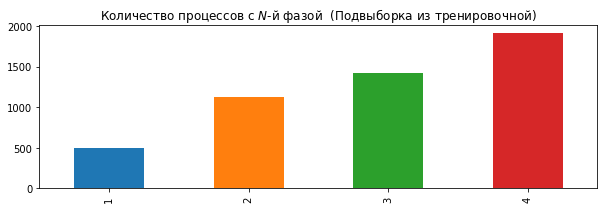

In [19]:
train_limited.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()
plt.title("Количество процессов с $N$-й фазой  (Подвыборка из тренировочной)");

### Feature engineering

In [20]:
def prep_metadata(df):
    # select process_id and pipeline
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    
    # convert categorical pipeline data to dummy variables
    meta = pd.get_dummies(meta)
    
    # pipeline L12 not in test data
    if 'L12' not in meta.columns:
        meta['pipeline_L12'] = 0
    
    # calculate number of phases for each process_object
    meta['num_phases'] = df.groupby('process_id')['phase'].apply(lambda x: x.nunique())
    
    return meta

# show example for first 5,000 observations
prep_metadata(train_limited.head(5000)).index.nunique()

6

In [21]:
#train_limited_with_phases_gr = train_limited.head(15).copy()
#phases = ['acid', 'caustic', 'pre_rinse']
#cols = train_limited_with_phases_gr.columns
#for col in cols[3:]:
#    for process in train_limited_with_phases_gr['process_id'].unique():
#        for phase in phases:
#            train_limited_with_phases_gr[col + '_' + phase] = train_limited[col][(train_limited['process_id'] == process) & (train_limited['phase'] == phase)]

## Удалим процессы, object_id которых не присутствует в тестовой выборке.

In [22]:
different_objects = []
for object_id in train_data['object_id'].unique():
    if object_id not in test_data['object_id'].unique():
        different_objects.append(object_id)
different_objects

[971, 976, 910, 970, 920, 977]

In [23]:
train_limited = train_limited[~(train_limited['object_id'].isin(different_objects))]

In [24]:
train_labels = train_labels.loc[train_limited.process_id.unique()]

# Строим модели и тестируем их:

**Напишем функцию, которая считает ошибку предсказания. Для того, чтобы её можно было использовать вместе с sklearn воспользуемся sklearn.metrics.make_scorer:**

In [25]:
def mean_abs_percentage_err(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), np.full(np.shape(y_true), 290000)))

from sklearn.metrics import make_scorer
mape_modified_scorer = make_scorer(mean_abs_percentage_err, greater_is_better=False)
    

## Напишем функцию, которая тестирует модели на кросс-валидации и отложенной выборке

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
def models_validation(X, y, models, folds):
    tsCV = KFold(folds)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 13)
    i = 0
    for model in models:
        i = i + 1
        model.fit(X_train, y_train)
        print(i, 'model cross-val:', np.mean(cross_val_score(model, X, y, scoring=mape_modified_scorer, n_jobs=-1, cv= tsCV)))
        print(i, 'model on hold data:', mean_abs_percentage_err(model.predict(X_test), y_test))
        print('\n')
    return 0

## Воспользуемся GridSearchCV, чтобы найти оптимальные параметры для 

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split

In [26]:

X_train, X_test, y_train, y_test = train_test_split(train_features, np.ravel(train_labels),
                                    train_size=0.7, random_state=13)

rf_regressor = RandomForestRegressor(n_estimators=50, random_state=13, n_jobs=-1, max_leaf_nodes=165, 
                                     min_samples_leaf=8, min_samples_split=0.005
#                                     max_depth=23,
#                                    max_leaf_nodes= 100,
#                                     min_samples_leaf = 5,
                                     
      
                                    #max_features=17,
                                   # criterion = 'mse',
                                  
                                    )
rf_param_grid =  {
                  'n_estimators' : [50],
                  'random_state' : [13], 
                  #'n_jobs=-1' : [-1],
                  'max_depth' : [35],
                  'max_features' : [40, 50, 80],
                  'min_weight_fraction_leaf' : [0.5, 0.1, 0.01, 0.0001,  0.00001],
                  'min_impurity_decrease' : [0.00001, 0.001, 0.01, 0.1, 1],
                  'min_impurity_split' : [0.00001, 0.001, 0.01, 0.1, 0.5]
                 # 'min_samples_leaf' : list(np.arange(2, 13)) + [20, 25, 50],
                 # 'max_leaf_nodes' : list(np.arange(2, 13)) + [20, 25, 50]
                                        }                 
rf_grid = GridSearchCV(estimator=rf_regressor, cv=TimeSeriesSplit(5), verbose=2,
                       scoring=mape_modified_scorer, n_jobs=-1, param_grid=rf_param_grid)

#sgd_regr = SGDRegressor(penalty='elasticnet', penalty='l1')

NameError: name 'train_features' is not defined

## Оптимальные параметры и лучший результат rf:

In [66]:
#rf_grid.best_params_, rf_grid.best_score_
#({'max_depth': 20,
#  'max_features': 40,
#  'min_samples_leaf': 5,
#  'n_estimators': 100,
#  'random_state': 13},
# -0.6180501020995538)
#{'max_depth': 20,
#  'max_features': 50,
#  'max_leaf_nodes': 50,
#  'min_samples_leaf': 3,
#  'n_estimators': 100,
#  'random_state': 13},
# -0.6628379946829989

rf_after_grid = RandomForestRegressor(n_estimators=25, max_depth=35, #max_features=100, 
                                      min_samples_leaf=8, max_leaf_nodes = 200, min_samples_split=0.005,
                                      min_weight_fraction_leaf = 0.0001,
                                      min_impurity_decrease = 0.001,
                                      bootstrap=False,
                                      random_state=13)
rf_after_grid.fit(X_train, y_train)
#rf_grid.best_params_, rf_grid.best_score_

NameError: name 'X_train' is not defined

## Воспользуемся RFE для того, чтобы отобрать важные признаки:

In [60]:
from sklearn.svm import SVR
svr = SVR(C=0.01, epsilon=1, kernel='sigmoid', coef0=1, max_iter=1000)
from sklearn.linear_model import Ridge
ridge = Ridge(alpha =  0.9, random_state=13, max_iter = 1000, tol = 0.0000001)
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
train_data_scaled = train_features.copy()
train_data_scaled = minmax.fit_transform(train_data_scaled)
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(train_data_scaled, np.ravel(train_labels),
                                                                 train_size=0.7, random_state=13)


In [61]:
from sklearn.feature_selection import RFECV, SelectKBest
rfecv = RFECV(estimator=ridge, step = 1, n_jobs=-1, scoring=mape_modified_scorer,
              cv=TimeSeriesSplit(5))


In [62]:
rfecv.fit(X_train_scaled, y_train)

RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
   estimator=Ridge(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, random_state=13, solver='auto', tol=1e-07),
   min_features_to_select=1, n_jobs=-1,
   scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
   step=1, verbose=0)

In [64]:
mean_abs_percentage_err(rfecv.predict(X_test_scaled), y_test) -  0.9170895496280376
#2.1592417953441427

2.1832550643149027

In [65]:
models_validation(train_features, np.ravel(train_labels), [rf_after_grid], folds=5)

NameError: name 'rf_after_grid' is not defined

In [62]:
from sklearn.feature_selection import SelectPercentile
kbest = SelectPercentile(score_func=mape_modified_scorer)
kbest.fit(X=X_train, y=y_train)

TypeError: __call__() missing 1 required positional argument: 'y_true'

## Добавим Knn и проверим эту модель на шкалированных данных

In [59]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=7, p = 2)
extra_trees = ExtraTreesRegressor( n_estimators=200, max_depth=45, #max_features=100, 
                                      min_samples_leaf=5, min_samples_split=0.005,
                                      min_weight_fraction_leaf = 0.0001,
                                      min_impurity_decrease = 0.001,
                                      random_state=13)
bagging = BaggingRegressor(max_samples=0.85, n_estimators=10, )
svr = SVR(C=0.01, epsilon=1, kernel='sigmoid', coef0=1, max_iter=1000)
rdg = Ridge()
lss = Lasso()
els = ElasticNet(copy_X=True)
rfecv = RFECV(estimator=extra_trees, step = 15, n_jobs=-1, scoring=mape_modified_scorer,
              cv=TimeSeriesSplit(3))

NameError: name 'RFECV' is not defined

In [46]:
models_validation(train_data_scaled, np.ravel(train_labels), [knn, extra_trees, bagging, svr, rdg, lss, els], folds=5)

1 model cross-val: -1.2984858868075166
1 model on hold data: 3.1987743411088436


2 model cross-val: -1.0117036757498852
2 model on hold data: 3.04791758717017


3 model cross-val: -1.4379192969409227
3 model on hold data: 3.641191493764286


4 model cross-val: -2.4116018918505695
4 model on hold data: 0.9877977571959007


5 model cross-val: -1.2804308053712246
5 model on hold data: 3.330082066343979


6 model cross-val: -1.4474951438249117
6 model on hold data: 3.9409472102732113


7 model cross-val: -0.9970132470919354
7 model on hold data: 2.9015466184422363




0

## Результат сравним с RandomForest! Настроим knn:

In [152]:
knn_grid_params = {'n_neighbors' : list(np.arange(2, 10)) + [ 40, 41, 42, 43, 44, 45, 46, 47 ],
                  'leaf_size' : list(np.arange(2, 10) + [15, 20, 25, 30, 50, 70, 90, 110])}
knn_grid = GridSearchCV(estimator=knn, cv=TimeSeriesSplit(5), verbose=2,
                       scoring=mape_modified_scorer, n_jobs=-1, param_grid=knn_grid_params)

In [262]:
knn_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  4.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=7, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 40, 41, 42, 43, 44, 45, 46, 47], 'leaf_size': [17, 23, 29, 35, 56, 77, 98, 119]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_abs_percentage_err, greater_is_better=False),
       verbose=2)

In [196]:
knn_grid.best_params_, knn_grid.best_score_

NameError: name 'knn_grid' is not defined

In [47]:
knn_after_grid = KNeighborsRegressor(metric='braycurtis',n_neighbors=44, p=2, weights='distance')
knn_bagging = BaggingRegressor(base_estimator=knn_after_grid, max_samples=0.9, max_features=0.8, n_jobs=-1,
                              n_estimators=30)

In [48]:
models_validation(train_data_scaled, np.ravel(train_labels), [knn_after_grid], 5)

1 model cross-val: -1.0855751026543954
1 model on hold data: 2.859974779720699




0

In [67]:
knn_after_grid.fit(train_data_scaled, np.ravel(train_labels))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=44, p=3,
          weights='distance')

## Попробуем использовать

In [48]:
rf_after_grid.fit(train_data_scaled, np.ravel(train_labels))

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=35,
           max_features='auto', max_leaf_nodes=200,
           min_impurity_decrease=0.001, min_impurity_split=None,
           min_samples_leaf=8, min_samples_split=0.005,
           min_weight_fraction_leaf=0.0001, n_estimators=25, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [41]:
test_features = create_feature_matrix(test_data)


In [42]:
test_features = minmax.transform(test_features)

In [49]:
preds = rf_after_grid.predict(test_features)

In [50]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [51]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [52]:
my_submission.to_csv('./submissions/7th_try_to_beat_benchmark_2.csv')

In [79]:
mape_modified_scorer(rf_after_grid, X_test, y_test), mean_abs_percentage_err(rf_after_grid.predict(X_test), y_test)

(-0.549157172260939, 0.9148239861830831)

## Преобразуем данные: 

In [27]:
# variables we'll use to create our time series features
ts_cols = [
    'process_id',
#    'phase',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]
ts_cols_my = [
    'process_id',
    'phase',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

## Преобразуем признаки временного ряда

In [28]:
import scipy as sc
def prep_time_series_features(df, columns=None):
    if columns is None:
        columns = df.columns
    
    ts_df = df[ts_cols].set_index('process_id')
    # create features: min, max, mean, standard deviation, and mean of the last 50 observations
    ts_features = ts_df.groupby('process_id').aggregate(['min', 'max', 'mean', 'std',
                                                             lambda x: x.tail(50).mean(),
                                                             'sum', 'mad'])
    
    return ts_features

# show example for first 5,000 observations
prep_time_series_features(train_limited.head(5000), columns=ts_cols)

supply_flow                                                       \
                    min         max          mean           std     <lambda>   
process_id                                                                     
20001         47.019676   59396.703  50103.211842  11397.417702  54254.34044   
20002          7.233796   34295.430  27142.963425   8337.197885  29965.71168   
20003      -1244.213000  103096.070  30455.285348  10152.968335  33821.90396   
20004        -43.402780   48394.098  31099.263353  13132.729350  37438.94732   
20005          0.000000   31295.209  28241.716353   7107.794924  30874.34918   
20008       2723.524400   53461.370  29302.278623   9031.206946  32018.88022   

                                      supply_pressure                      \
                     sum          mad             min       max      mean   
process_id                                                                  
20001       6.814037e+07  7947.648538       -0.036024  2.223741  1.693400   
20002       1.210576e+07  5058.926236       -0.034071  2.170790  1.477925   
20003       6.447384e+07  6782.761736       -0.033854  3.859375  2.687741   
20004       2.301345e+07  9033.103545       -0.009549  0.471137  0.281616   
20005       7.173396e+06  4309.652939       -0.023438  0.487196  0.418469   
20008       2.432089e+06  5111.618406        0.174479  0.174913  0.174733   

                                                      return_temperature  \
                 std  <lambda>          sum       mad                min   
process_id                                                                 
20001       0.290767  1.685799  2303.023875  0.134970          13.888889   
20002       0.421852  1.594106   659.154517  0.233771           8.742043   
20003       0.858450  2.958954  5689.948363  0.533843          11.024305   
20004       0.161467  0.300256   208.395834  0.147526          28.757957   
20005       0.128794  0.466693   106.291016  0.080627          17.986834   
20008       0.000111  0.174683    14.502821  0.000083          10.481771   

                                                                       \
                  max       mean        std   <lambda>            sum   
process_id                                                              
20001       82.530380  65.577520  22.264019  72.523799   89185.427283   
20002       76.392510  53.616841  22.887856  75.737052   23913.111281   
20003       81.586370  60.850462  22.457923  71.469688  128820.428049   
20004       82.490590  70.845547  15.281445  71.663918   52425.705100   
20005       71.520546  58.049278  19.047244  71.013527   14744.516710   
20008       30.240885  20.152616   7.770991  24.809245    1672.667104   

                      return_conductivity                                   \
                  mad                 min        max       mean        std   
process_id                                                                   
20001       18.956638            0.255486  57.301300  33.337032  18.263087   
20002       19.047595            0.172301  46.425180  30.834840  17.792754   
20003       20.322458            0.205189  46.821130  29.609697  19.206738   
20004       10.670704            1.764006  48.217014  37.523789  13.350097   
20005       16.841919            0.297533  50.747000  33.776595  18.339520   
20008        7.377320            0.271332   5.449392   1.557561   1.213623   

                                               return_turbidity             \
             <lambda>           sum        mad              min        max   
process_id                                                                   
20001       42.951021  45338.363521  15.751095         0.122975  45.026764   
20002       41.841575  13752.338555  15.472070         0.307436  74.844475   
20003       43.928918  62683.729351  17.778131         0.061487  60.394966   
20004       44.332618  27767.604187  10.005679         0.289352  72.956450   
20005

In [48]:
import scipy as sc
def tail50mean(x):
    return x.tail(50).mean()

def tail30std(x):
    return x.tail(30).std()

def tail30median(x):
    return x.tail(30).median()



def prep_time_series_features_my(df, columns=None):
    if columns is None:
        columns = df.columns
    
    ts_df = df[ts_cols_my].set_index('process_id')
    phases = ['pre_rinse', 'caustic', 'intermediate_rinse', 'acid']
    # create features: min, max, mean, standard deviation, and mean of the last 50 observations
    ts_features = ts_df.groupby(['process_id', 'phase']).aggregate(['min', 'max', 'mean', 'std',
                                                             tail50mean,
                                                             'mad',
                                                             'sum'
                                                        ])
    ts_features_sep_phases = pd.DataFrame(ts_df.index.unique())
    ts_features = ts_features.reset_index(level=[0,1])
    ts_features.index = ts_features['process_id']
    ts_features.pop('process_id')
    ts_features_sep_phases.index = ts_features_sep_phases['process_id']
    ts_features_sep_phases.pop('process_id')
    # Для каждой фазы процесса будут отдельные характеристики:
    for col in ts_features.columns[1:]:
        for phase in phases:
            ts_features_sep_phases[str(col) + '_' + phase] = ts_features[col][ts_features['phase'] == phase]
    for col in ts_features_sep_phases.columns:
        ts_features_sep_phases[col].fillna(value = ts_features_sep_phases[col].mean(), inplace = True)
    #ts_features_sep_phases.fillna(value = -5000, inplace=True)
    return ts_features_sep_phases

# show example for first 5,000 observations
train_features_check = prep_time_series_features_my(train_limited.head(5000), columns=ts_cols)

In [49]:
train_features_check

,"('supply_flow', 'min')_pre_rinse","('supply_flow', 'min')_caustic","('supply_flow', 'min')_intermediate_rinse","('supply_flow', 'min')_acid","('supply_flow', 'max')_pre_rinse","('supply_flow', 'max')_caustic","('supply_flow', 'max')_intermediate_rinse","('supply_flow', 'max')_acid","('supply_flow', 'mean')_pre_rinse","('supply_flow', 'mean')_caustic","('supply_flow', 'mean')_intermediate_rinse","('supply_flow', 'mean')_acid","('supply_flow', 'std')_pre_rinse","('supply_flow', 'std')_caustic","('supply_flow', 'std')_intermediate_rinse","('supply_flow', 'std')_acid","('supply_flow', 'tail50mean')_pre_rinse","('supply_flow', 'tail50mean')_caustic","('supply_flow', 'tail50mean')_intermediate_rinse","('supply_flow', 'tail50mean')_acid","('supply_flow', 'mad')_pre_rinse","('supply_flow', 'mad')_caustic","('supply_flow', 'mad')_intermediate_rinse","('supply_flow', 'mad')_acid","('supply_flow', 'sum')_pre_rinse","('supply_flow', 'sum')_caustic","('supply_flow', 'sum')_intermediate_rinse","('supply_flow', 'sum')_acid","('supply_pressure', 'min')_pre_rinse","('supply_pressure', 'min')_caustic","('supply_pressure', 'min')_intermediate_rinse","('supply_pressure', 'min')_acid","('supply_pressure', 'max')_pre_rinse","('supply_pressure', 'max')_caustic","('supply_pressure', 'max')_intermediate_rinse","('supply_pressure', 'max')_acid","('supply_pressure', 'mean')_pre_rinse","('supply_pressure', 'mean')_caustic","('supply_pressure', 'mean')_intermediate_rinse","('supply_pressure', 'mean')_acid","('supply_pressure', 'std')_pre_rinse","('supply_pressure', 'std')_caustic","('supply_pressure', 'std')_intermediate_rinse","('supply_pressure', 'std')_acid","('supply_pressure', 'tail50mean')_pre_rinse","('supply_pressure', 'tail50mean')_caustic","('supply_pressure', 'tail50mean')_intermediate_rinse","('supply_pressure', 'tail50mean')_acid","('supply_pressure', 'mad')_pre_rinse","('supply_pressure', 'mad')_caustic","('supply_pressure', 'mad')_intermediate_rinse","('supply_pressure', 'mad')_acid","('supply_pressure', 'sum')_pre_rinse","('supply_pressure', 'sum')_caustic","('supply_pressure', 'sum')_intermediate_rinse","('supply_pressure', 'sum')_acid","('return_temperature', 'min')_pre_rinse","('return_temperature', 'min')_caustic","('return_temperature', 'min')_intermediate_rinse","('return_temperature', 'min')_acid","('return_temperature', 'max')_pre_rinse","('return_temperature', 'max')_caustic","('return_temperature', 'max')_intermediate_rinse","('return_temperature', 'max')_acid","('return_temperature', 'mean')_pre_rinse","('return_temperature', 'mean')_caustic","('return_temperature', 'mean')_intermediate_rinse","('return_temperature', 'mean')_acid","('return_temperature', 'std')_pre_rinse","('return_temperature', 'std')_caustic","('return_temperature', 'std')_intermediate_rinse","('return_temperature', 'std')_acid","('return_temperature', 'tail50mean')_pre_rinse","('return_temperature', 'tail50mean')_caustic","('return_temperature', 'tail50mean')_intermediate_rinse","('return_temperature', 'tail50mean')_acid","('return_temperature', 'mad')_pre_rinse","('return_temperature', 'mad')_caustic","('return_temperature', 'mad')_intermediate_rinse","('return_temperature', 'mad')_acid","('return_temperature', 'sum')_pre_rinse","('return_temperature', 'sum')_caustic","('return_temperature', 'sum')_intermediate_rinse","('return_temperature', 'sum')_acid","('return_conductivity', 'min')_pre_rinse","('return_conductivity', 'min')_caustic","('return_conductivity', 'min')_intermediate_rinse","('return_conductivity', 'min')_acid","('return_conductivity', 'max')_pre_rinse","('return_conductivity', 'max')_caustic","('return_conductivity', 'max')_intermediate_rinse","('return_conductivity', 'max')_acid","('return_conductivity', 'mean')_pre_rinse","('return_conductivity', 'mean')_caustic","('return_conductivity', 'mean')_intermediate_rinse","('return_conductivity', 'mean')_acid","('return_conductivity', 'std')_pre_rinse","('return_conductivity', 'std')_caustic","('

In [50]:
def create_feature_matrix(df, flag):
    metadata = prep_metadata(df)
    if flag == 0:
        time_series = prep_time_series_features(df)
    else:
        time_series = prep_time_series_features_my(df)
    # join metadata and time series features into a single dataframe
    feature_matrix = pd.concat([metadata, time_series], axis=1)
    
    
    return feature_matrix

In [53]:
train_features = create_feature_matrix(train_limited, 1)

In [54]:
train_features.head(10)

,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,pipeline_L9,pipeline_L12,num_phases,"('supply_flow', 'min')_pre_rinse","('supply_flow', 'min')_caustic","('supply_flow', 'min')_intermediate_rinse","('supply_flow', 'min')_acid","('supply_flow', 'max')_pre_rinse","('supply_flow', 'max')_caustic","('supply_flow', 'max')_intermediate_rinse","('supply_flow', 'max')_acid","('supply_flow', 'mean')_pre_rinse","('supply_flow', 'mean')_caustic","('supply_flow', 'mean')_intermediate_rinse","('supply_flow', 'mean')_acid","('supply_flow', 'std')_pre_rinse","('supply_flow', 'std')_caustic","('supply_flow', 'std')_intermediate_rinse","('supply_flow', 'std')_acid","('supply_flow', 'tail50mean')_pre_rinse","('supply_flow', 'tail50mean')_caustic","('supply_flow', 'tail50mean')_intermediate_rinse","('supply_flow', 'tail50mean')_acid","('supply_flow', 'mad')_pre_rinse","('supply_flow', 'mad')_caustic","('supply_flow', 'mad')_intermediate_rinse","('supply_flow', 'mad')_acid","('supply_flow', 'sum')_pre_rinse","('supply_flow', 'sum')_caustic","('supply_flow', 'sum')_intermediate_rinse","('supply_flow', 'sum')_acid","('supply_pressure', 'min')_pre_rinse","('supply_pressure', 'min')_caustic","('supply_pressure', 'min')_intermediate_rinse","('supply_pressure', 'min')_acid","('supply_pressure', 'max')_pre_rinse","('supply_pressure', 'max')_caustic","('supply_pressure', 'max')_intermediate_rinse","('supply_pressure', 'max')_acid","('supply_pressure', 'mean')_pre_rinse","('supply_pressure', 'mean')_caustic","('supply_pressure', 'mean')_intermediate_rinse","('supply_pressure', 'mean')_acid","('supply_pressure', 'std')_pre_rinse","('supply_pressure', 'std')_caustic","('supply_pressure', 'std')_intermediate_rinse","('supply_pressure', 'std')_acid","('supply_pressure', 'tail50mean')_pre_rinse","('supply_pressure', 'tail50mean')_caustic","('supply_pressure', 'tail50mean')_intermediate_rinse","('supply_pressure', 'tail50mean')_acid","('supply_pressure', 'mad')_pre_rinse","('supply_pressure', 'mad')_caustic","('supply_pressure', 'mad')_intermediate_rinse","('supply_pressure', 'mad')_acid","('supply_pressure', 'sum')_pre_rinse","('supply_pressure', 'sum')_caustic","('supply_pressure', 'sum')_intermediate_rinse","('supply_pressure', 'sum')_acid","('return_temperature', 'min')_pre_rinse","('return_temperature', 'min')_caustic","('return_temperature', 'min')_intermediate_rinse","('return_temperature', 'min')_acid","('return_temperature', 'max')_pre_rinse","('return_temperature', 'max')_caustic","('return_temperature', 'max')_intermediate_rinse","('return_temperature', 'max')_acid","('return_temperature', 'mean')_pre_rinse","('return_temperature', 'mean')_caustic","('return_temperature', 'mean')_intermediate_rinse","('return_temperature', 'mean')_acid","('return_temperature', 'std')_pre_rinse","('return_temperature', 'std')_caustic","('return_temperature', 'std')_intermediate_rinse","('return_temperature', 'std')_acid","('return_temperature', 'tail50mean')_pre_rinse","('return_temperature', 'tail50mean')_caustic","('return_temperature', 'tail50mean')_intermediate_rinse","('return_temperature', 'tail50mean')_acid","('return_temperature', 'mad')_pre_rinse","('return_temperature', 'mad')_caustic","('return_temperature', 'mad')_intermediate_rinse","('return_temperature', 'mad')_acid","('return_temperature', 'sum')_pre_rinse","('return_temperature', 'sum')_caustic","('return_temperature', 'sum')_intermediate_rinse","('return_temperature', 'sum')_acid","('return_conductivity', 'min')_pre_rinse","('return_conductivity', 'min')_caustic","('return_conductivity', 'min')_intermediate_rinse","('return_conductivity', 'min')_acid","('return_conductivity', 'max')_pre_rinse","('return_conductivity', 'max')_caustic","('return_conductivity', 'max')_intermediate_rinse","('return_conductivity', 'max')_acid","('return_conductivity', 'mean')_pre_rinse","('return_conductivity', 'mean')_caustic","('return_conductivity', 'mean')_

# Все-таки попробуем XGB:

In [55]:
# так как не любит присутствие данных символов в названиях признаков
train_features_xgb = train_features.copy()
for col_name in train_features_xgb.columns:
    new_col_name = str(col_name).replace(">", "")
    new_col_name = str(new_col_name).replace("<", "")
    new_col_name = str(new_col_name).replace(",", "")
    new_col_name = str(new_col_name).replace("[", "")
    new_col_name = str(new_col_name).replace("]", "")
    train_features_xgb[new_col_name] = train_features_xgb[col_name]
    train_features_xgb.pop(col_name)

In [56]:
from xgboost import XGBRegressor
xgb = XGBRegressor(booster='gbtree', n_estimators=1000, max_depth=4, n_jobs=-1,
                  learning_rate=0.05, min_child_weight=2, 
                  random_state=13, colsample_bytree=0.85, colsample_bylevel=1,
                  objective='reg:tweedie', subsample = 0.75, tweedie_variance_power = 2               )


In [57]:
models_validation(train_features_xgb, np.ravel(train_labels), [xgb], 4)
#1 model cross-val: -0.6976118997139746    / 2500, 4
#1 model on hold data: 0.4225839457350144 

#1 model cross-val: -0.628342546601321  // full_train, value = -500
#1 model on hold data: 0.35848399642714535


#1 model cross-val: -0.6797203086008728  //1000, 4
#1 model on hold data: 0.4376841697925037

#1 model cross-val: -0.6458567155913184     //full train
#1 model on hold data: 0.39365593013255623




#1 model cross-val: -0.6980819678522877   //1000, 4, // without objects
#1 model on hold data: 0.4078492689251406

#1 model cross-val: -0.5975201510398016   // full train, value = mean
#1 model on hold data: 0.3782901096158676

#1 model cross-val: -0.6198080922886419   // value = -500000
#1 model on hold data: 0.3639437758412007

#1 model cross-val: -0.6148424080614234   // value = -500
#1 model on hold data: 0.37352344676955995


#1 model cross-val: -0.7083886612578387     1000, 5
#1 model on hold data: 0.4214137427647076

#1 model cross-val: -0.6980819678522877  // 1000, 5; without objects
#1 model on hold data: 0.4078492689251406

1 model cross-val: -0.6980819678522877
1 model on hold data: 0.4078492689251406




0

In [77]:
test_data.describe() - train_data.describe()

,process_id,object_id,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_acid,tank_lsh_pre_rinse
count,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2.595333e+06,-2595333.0,-2595333.0
mean,-1.077341e+02,-7.135175e+00,7.428058e+02,-6.938616e-03,-6.737600e-01,-1.528117e+00,7.463256e-01,5.940341e+02,-1.469070e-01,1.567620e-01,5.294454e-03,1.029847e+00,2.555917e+00,6.503215e-02,-7.255785e-03,3.571505e-02,1.643652e-01,0.0,0.0
std,-1.055440e+01,-1.508091e+00,-2.494920e+02,-5.357469e-02,5.293909e-01,7.540666e-01,8.154231e-01,3.471183e+00,2.843282e-02,3.976881e-01,-2.698183e-01,-1.545691e+00,-3.575082e-01,-1.634493e+00,2.374265e-02,-5.137537e-01,-2.895666e-01,0.0,0.0
min,-1.000000e+00,0.000000e+00,3.555556e+04,0.000000e+00,5.700232e+00,1.575748e-04,2.929687e-01,3.617000e+00,3.358850e+01,2.509440e+01,6.596863e+00,1.092032e+01,2.668909e+01,7.739439e+01,-1.388884e+00,8.901274e+00,3.733439e+01,0.0,0.0
25%,-1.560000e+02,0.000000e+00,5.443433e+02,-2.973090e-02,-9.006100e-01,-5.570937e-01,7.233795e-02,1.949507e+02,-3.291300e-02,1.081440e-01,6.347700e-02,4.654960e-01,2.882665e+00,1.808200e-02,-7.230000e-03,2.077100e-02,5.008000e-02,0.0,0.0
50%,-2.530000e+02,-1.500000e+01,1.967591e+03,6.054688e-02,7.016800e-01,-1.433000e-01,2.821181e-01,1.193576e+03,-1.857250e-01,1.880760e-01,8.934000e-02,5.148630e-01,2.578848e+00,1.808000e-02,-7.230000e-03,1.844500e-02,7.664000e-02,0.0,0.0
75%,-7.000000e+00,-1.000000e+00,5.787030e+02,1.519100e-03,6.293440e-01,8.544000e-03,9.910300e-01,2.640320e+02,-2.139400e-01,3.738070e-01,-7.052500e-02,3.479440e-01,2.228010e+00,7.230000e-03,3.616000e-03,4.665000e-03,1.330760e-01,0.0,0.0
max,1.000000e+00,-1.100000e+01,7.240000e+00,-2.170000e-04,-3.562640e+00,9.142845e+01,2.097700e-01,-1.087000e+01,-2.351000e-02,3.110350e+00,-1.025028e+00,-1.434070e-01,-6.655080e-01,3.979000e-02,-1.085060e-01,-4.701680e+00,-1.845446e+00,0.0,0.0


In [69]:
train_data.head(500000).describe()

,process_id,object_id,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_acid,tank_lsh_pre_rinse
count,500000.000000,500000.00000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.0,500000.0
mean,20437.627222,566.73965,22370.137307,1.095370,59.041755,30.929376,3.644223,21283.375909,53.046231,42.207890,44.090683,43.070230,28.588164,82.447553,72.575112,45.261764,44.451928,0.0,0.0
std,256.257659,351.58803,16702.635436,1.348037,23.217635,19.945618,7.703957,17497.646162,3.887275,2.756056,2.303015,6.673011,1.757043,0.537778,0.402179,0.809229,0.807580,0.0,0.0
min,20001.000000,102.00000,-1244.213000,-0.114583,4.777923,0.000000,-0.097656,-1247.829800,34.159794,25.672745,32.288410,3.832104,23.802807,77.672890,67.751730,25.697956,36.464394,0.0,0.0
25%,20206.000000,216.00000,5998.263700,0.075955,33.080150,2.561961,0.423177,3868.272500,50.626083,40.730797,42.754990,41.062286,27.202690,82.241030,72.392220,45.128357,44.320360,0.0,0.0
50%,20435.000000,420.00000,22453.703000,0.418403,69.730180,42.835258,1.142940,20269.098000,54.018555,42.411747,44.135020,44.356010,28.540941,82.534000,72.609230,45.290040,44.520916,0.0,0.0
75%,20664.000000,934.00000,32570.168000,1.947700,78.649450,44.639636,2.361835,34113.226250,56.056854,43.935184,45.444515,47.520435,29.857496,82.808880,72.819016,45.457413,44.757460,0.0,0.0
max,20889.000000,971.00000,103157.555000,6.194010,93.070020,73.565890,89.644820,103132.234000,58.318504,50.941116,52.441044,50.494430,35.402200,83.510560,73.918550,58.582954,58.633060,0.0,0.0


In [70]:
test_data.head(500000).describe()

,process_id,object_id,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,return_flow,tank_level_pre_rinse,tank_level_caustic,tank_level_acid,tank_level_clean_water,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_acid,tank_lsh_pre_rinse
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.0,500000.0
mean,21016.991210,557.104036,23537.038227,1.074871,58.192106,29.180848,4.460718,22330.344216,52.826187,42.327981,44.126514,44.182381,31.119001,82.463945,72.563318,45.293782,44.614487,0.0,0.0
std,562.657251,347.035321,17318.164917,1.324351,24.122027,20.629303,8.550502,18237.295509,3.845746,3.643851,2.091385,4.688763,1.510425,0.525111,0.421489,0.440352,0.783353,0.0,0.0
min,20000.000000,102.000000,-1240.596100,-0.114583,7.074653,0.000186,-0.050637,-1247.829800,37.618090,25.094402,34.378437,20.145580,26.732496,77.394390,67.686630,34.599230,37.334390,0.0,0.0
25%,20546.000000,216.000000,6599.030300,0.062934,31.253618,1.853318,0.481047,3984.375000,50.412144,40.733143,42.839630,41.454900,30.027489,82.273580,72.381360,45.156837,44.363709,0.0,0.0
50%,21030.000000,405.000000,23007.090000,0.448785,70.446330,42.582398,1.414207,21553.098000,53.698822,42.623337,44.226707,44.755680,31.054688,82.555700,72.594765,45.304982,44.589519,0.0,0.0
75%,21511.000000,932.000000,33570.240000,1.855035,79.437935,44.613601,3.425203,35141.780000,55.833515,44.464157,45.559715,47.758472,32.052950,82.812500,72.819016,45.460744,44.897496,0.0,0.0
max,22019.000000,966.000000,103161.170000,6.193793,93.265335,70.660210,93.348526,103117.766000,58.325558,54.305374,51.249096,50.492080,37.123844,83.543110,73.867910,55.602425,63.395460,0.0,0.0


## Попробуем использовать

In [122]:
xgb.fit(train_features_xgb, np.ravel(train_labels))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=4, min_child_weight=2, missing=None,
       n_estimators=2500, n_jobs=-1, nthread=None, objective='reg:tweedie',
       random_state=13, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.75, tweedie_variance_power=2)

In [125]:
test_features = create_feature_matrix(test_data, 1)


In [127]:
# так как не любит присутствие данных символов в названиях признаков
test_features_xgb = test_features.copy()
for col_name in test_features_xgb.columns:
    new_col_name = str(col_name).replace(">", "")
    new_col_name = str(new_col_name).replace("<", "")
    new_col_name = str(new_col_name).replace(",", "")
    new_col_name = str(new_col_name).replace("[", "")
    new_col_name = str(new_col_name).replace("]", "")
    test_features_xgb[new_col_name] = test_features_xgb[col_name]
    test_features_xgb.pop(col_name)

In [129]:
preds = xgb.predict(test_features_xgb)

In [130]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [131]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [132]:
my_submission.to_csv('./submissions/16th_submission.csv')

In [58]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
ridge_param_grid = {'alpha' : [1.001, 20000, 0.00000001, 0.00001, 0.00004, 0.5, 0.8, 0.9],
                    'tol' : list(0.1 + np.arange(50) / 5000) + [1, 2, 5, 10]}
ridge = Ridge(normalize=True, fit_intercept=True, max_iter=500 )
ridge_grid = GridSearchCV(estimator=ridge, param_grid=ridge_param_grid, cv=TimeSeriesSplit(5), 
                         verbose=1, scoring=mape_modified_scorer)
ridge_grid.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [90]:
ridge_grid.best_params_

{'alpha': 1.001, 'tol': 0.1}

In [91]:
mape_modified_scorer(ridge_grid, X_test, y_test), mean_abs_percentage_err(ridge_grid.predict(X_test), y_test)

(-0.8668668309153095, 2.147872467088798)

In [56]:
preds = sgd.predict(test_features)

In [57]:
submission_format = pd.read_csv('./data/submission_format.csv', index_col=0)

In [58]:
my_submission = pd.DataFrame(data=preds,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [59]:
my_submission.to_csv('./submissions/4th_try_to_beat_benchmark.csv')

In [134]:
subm_1 = pd.read_csv('./submissions/16th_submission.csv', index_col=0)
subm_2 = pd.read_csv('./submissions/15th_submission.csv', index_col=0)
np.mean(subm_1['final_rinse_total_turbidity_liter'] - subm_2['final_rinse_total_turbidity_liter'])

-48904.96141220076

74322.23702776793